## Experiment 2: Model Robustness  
This experiment will measure the performance of the models in being able to adapt to large changes in the goal distribution of an agent. We will generate new episode data (~10 episodes) after significantly changing the goal distributions of the agents. We will then measure change in performance from before. 
  
Steps:
  
1. Load agents and data from experiment 0
2. Run the models and get score information
3. Change the goal distributions of the agents
4. Generate new data
5. Run the models and get new score information
6. Visualize the difference

In [78]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
import numpy as np
import pymc
import networkx as nx
import matplotlib.pyplot as plt
import random
import json
from tqdm import tqdm

In [80]:
import sys
import os
import osmnx as ox

# Adjust this path as needed to point to your project root
sys.path.append(os.path.abspath(".."))

In [81]:
from real_world_src.environment.campus_env import CampusEnvironment
from real_world_src.agents.agent_factory import AgentFactory
from real_world_src.agents.agent_species import ShortestPathAgent
from real_world_src.simulation.simulator import Simulator
#from real_world_src.simulation.experiment_1 import Simulator

from real_world_src.utils.run_manager import RunManager
from real_world_src.utils.config import VISUAL_CONFIG
from real_world_src.utils.config import get_agent_color

## Step 1: Loading the Data

In [82]:
# Create a run manager
#run_manager = RunManager('visuals')
#run_dir = run_manager.start_new_run()

# Initialize campus environment
campus = CampusEnvironment()

Loading graph from ././../notebooks/ucsd_campus.graphml...
Environment loaded with 3151 nodes and 8746 edges
Environment loaded with 3151 nodes and 8746 edges


In [83]:
# Need to establish the set of common goals (just choose the landmark nodes)
goals = [469084068, 49150691, 768264666, 1926666015, 1926673385, 49309735,
         273627682, 445989107, 445992528, 446128310, 1772230346, 1926673336, 
         2872424923, 3139419286, 4037576308]

In [84]:
import pickle
# if you used dill, just replace pickle with dill

with open('./../data/100/agents.pkl', 'rb') as f:
    agents = pickle.load(f)

In [85]:
with open("./../data/100/path_data.json", 'r') as file:
    path_data = json.load(file)

with open("./../data/100/goal_data.json", 'r') as file:
    goal_data = json.load(file)

In [86]:
def convert_keys_to_int(data):
    if isinstance(data, dict):
        return {int(k) if isinstance(k, str) and k.isdigit() else k: convert_keys_to_int(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [convert_keys_to_int(item) for item in data]
    else:
        return data

In [87]:
goal_data = convert_keys_to_int(goal_data)
path_data = convert_keys_to_int(path_data)

## Step 2: Running the Models on Old Data

In [88]:
from real_world_src.utils.metrics import brier_along_path, accuracy_along_path, fooled_along_path

### BToM

In [89]:
# Import BToM baseline
from real_world_src.models.btom import BToM

In [90]:
btom = BToM(campus, agents, goals)

Computing shortest paths...
Done
Done


In [95]:
# Calculate all the posteriors using the first 30 episode
posteriors_data = {}

for episode in range(len(goal_data)):
    posteriors_data[episode] = {}
    for agent in agents:
        # Filter path to only include valid nodes in the graph
        valid_path = [n for n in path_data[episode][agent.id] if n in btom.campus.G.nodes]
        if len(valid_path) < 2:
            continue  # skip short or invalid paths
        posteriors_data[episode][agent.id] = btom.update_agent_posterior_over_path(agent, valid_path)
    # Reset the posteriors for new episode
    btom.reset_posteriors()

In [92]:
orig_scores_btom = []
min_len = min(len(valid_path), len(posteriors_data[episode][agent.id]))
orig_scores_btom.append(brier_along_path(
    valid_path[:min_len],
    goal_data[episode][agent.id],
    posteriors_data[episode][agent.id][:min_len],
    goals
))

In [93]:
"""
orig_scores_btom = []
for episode in range(len(goal_data)):
    for agent in agents:
        # Use the same filtered path as in inference
        valid_path = [n for n in path_data[episode][agent.id] if n in btom.campus.G.nodes]
        if len(valid_path) < 2 or agent.id not in posteriors_data[episode]:
            continue
        orig_scores_btom.append(brier_along_path(
            valid_path,
            goal_data[episode][agent.id],
            posteriors_data[episode][agent.id],
            goals
        ))
        """


'\norig_scores_btom = []\nfor episode in range(len(goal_data)):\n    for agent in agents:\n        # Use the same filtered path as in inference\n        valid_path = [n for n in path_data[episode][agent.id] if n in btom.campus.G.nodes]\n        if len(valid_path) < 2 or agent.id not in posteriors_data[episode]:\n            continue\n        orig_scores_btom.append(brier_along_path(\n            valid_path,\n            goal_data[episode][agent.id],\n            posteriors_data[episode][agent.id],\n            goals\n        ))\n        '

In [94]:
btom_orig_accuracy = []
min_len = min(len(valid_path), len(posteriors_data[episode][agent.id]))
btom_orig_accuracy.append(accuracy_along_path(
    valid_path[:min_len],
    goal_data[episode][agent.id],
    posteriors_data[episode][agent.id][:min_len],
    goals
))

In [54]:
""" 
btom_orig_accuracy = []
for episode in range(len(goal_data)):
    for agent in agents:
        # Use the same filtered path as in inference
        valid_path = [n for n in path_data[episode][agent.id] if n in btom.campus.G.nodes]
        if len(valid_path) < 2 or agent.id not in posteriors_data[episode]:
            continue
        btom_orig_accuracy.append(accuracy_along_path(
            valid_path,
            goal_data[episode][agent.id],
            posteriors_data[episode][agent.id],
            goals
        ))
        """

' \nbtom_orig_accuracy = []\nfor episode in range(len(goal_data)):\n    for agent in agents:\n        # Use the same filtered path as in inference\n        valid_path = [n for n in path_data[episode][agent.id] if n in btom.campus.G.nodes]\n        if len(valid_path) < 2 or agent.id not in posteriors_data[episode]:\n            continue\n        btom_orig_accuracy.append(accuracy_along_path(\n            valid_path,\n            goal_data[episode][agent.id],\n            posteriors_data[episode][agent.id],\n            goals\n        ))\n        '

pickle and json

In [179]:
import pickle
with open('btom_posteriors.pkl', 'wb') as f:
    pickle.dump(posteriors_data, f)

In [180]:
import json
with open('btom_posteriors.json', 'w') as f:
    json.dump(posteriors_data, f, indent=2)

### Extended BToM

In [100]:
from real_world_src.models.extended_btom import Extended_BToM

In [101]:
with open('./extended_btom.pkl', 'rb') as f:
    ext_btom = pickle.load(f)

In [111]:
# Define valid_path for each agent and use it for posterior update, following Campus_Experiment_0 style

ext_posteriors_data = {}

for episode in range(len(path_data)):
    ext_posteriors_data[episode] = {}
    for agent in agents:
        # Filter path to only include valid nodes in the graph
        valid_path = [n for n in path_data[episode][agent.id] if n in ext_btom.campus.G.nodes]
        if len(valid_path) < 2:
            print(f"Skipping agent {agent.id} in episode {episode}: not enough valid nodes in path.")
            continue
        ext_posteriors_data[episode][agent.id] = ext_btom.update_agent_posterior_over_path(agent, valid_path)

In [112]:
"""# Calculate orig_scores_ext using the same valid_path logic
# Robustly compute orig_scores_ext to avoid IndexError by slicing to min length
orig_scores_ext = []
for episode in range(len(goal_data)):
    for agent in agents:
        path = path_data[episode][agent.id]
        posteriors = ext_posteriors_data[episode][agent.id]
        min_len = min(len(path), len(posteriors))
        orig_scores_ext.append(brier_along_path(
            path[:min_len],
            goal_data[episode][agent.id],
            posteriors[:min_len],
            goals
        ))
        """

'# Calculate orig_scores_ext using the same valid_path logic\n# Robustly compute orig_scores_ext to avoid IndexError by slicing to min length\norig_scores_ext = []\nfor episode in range(len(goal_data)):\n    for agent in agents:\n        path = path_data[episode][agent.id]\n        posteriors = ext_posteriors_data[episode][agent.id]\n        min_len = min(len(path), len(posteriors))\n        orig_scores_ext.append(brier_along_path(\n            path[:min_len],\n            goal_data[episode][agent.id],\n            posteriors[:min_len],\n            goals\n        ))\n        '

In [113]:
"""
orig_scores_ext = []
for episode in range(len(goal_data)):
    for agent in agents:
        orig_scores_ext.append(brier_along_path(path_data[episode][agent.id], 
                                  goal_data[episode][agent.id], 
                                  ext_posteriors_data[episode][agent.id], 
                                  goals))
                                  """

'\norig_scores_ext = []\nfor episode in range(len(goal_data)):\n    for agent in agents:\n        orig_scores_ext.append(brier_along_path(path_data[episode][agent.id], \n                                  goal_data[episode][agent.id], \n                                  ext_posteriors_data[episode][agent.id], \n                                  goals))\n                                  '

pickle and json files

In [181]:
import json
with open('ebtom_posteriors.json', 'w') as f:
    json.dump(ext_posteriors_data, f, indent=2)

In [182]:
import pickle
with open('ebtom_posteriors.pkl', 'wb') as f:
    pickle.dump(ext_posteriors_data, f)

# LSTM

In [114]:
# --- LSTM Implementation (Old Data) ---
from real_world_src.models.lstm import (
    SimpleLSTM, LSTMDataset, lstm_collate_fn,
    train_lstm_model, evaluate_lstm_model, predict_goal_posterior
)
from torch.utils.data import DataLoader
import torch

In [115]:
# Build node2idx and goal2idx
all_nodes = list(campus.G_undirected.nodes())
node2idx  = {n:i for i,n in enumerate(all_nodes)}
goal2idx = {g:i for i,g in enumerate(goals)}


In [117]:
# Prepare dataset and dataloader
# Batch size = 32
# Filter all paths to only include valid nodes in node2idx
valid_path_data = {}
for episode in path_data:
    valid_path_data[episode] = {}
    for agent_id, path in path_data[episode].items():
        valid_path = [n for n in path if n in node2idx]
        valid_path_data[episode][agent_id] = valid_path

lstm_dataset = LSTMDataset(valid_path_data, goal_data, node2idx, goal2idx)
lstm_loader = DataLoader(lstm_dataset, batch_size=32, shuffle=True, collate_fn=lstm_collate_fn)

In [118]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [119]:
# Instantiate and train the model
lstm_model = SimpleLSTM(num_nodes=len(node2idx), num_goals=len(goal2idx)).to(device)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)
train_lstm_model(lstm_model, lstm_loader, optimizer, device, num_epochs=10)

Epoch 1/10 - Loss: 2.5286
Epoch 2/10 - Loss: 2.0448
Epoch 2/10 - Loss: 2.0448
Epoch 3/10 - Loss: 2.2714
Epoch 3/10 - Loss: 2.2714
Epoch 4/10 - Loss: 1.9787
Epoch 4/10 - Loss: 1.9787
Epoch 5/10 - Loss: 2.0935
Epoch 5/10 - Loss: 2.0935
Epoch 6/10 - Loss: 1.8645
Epoch 6/10 - Loss: 1.8645
Epoch 7/10 - Loss: 1.9992
Epoch 7/10 - Loss: 1.9992
Epoch 8/10 - Loss: 1.9907
Epoch 8/10 - Loss: 1.9907
Epoch 9/10 - Loss: 2.0370
Epoch 9/10 - Loss: 2.0370
Epoch 10/10 - Loss: 1.8533
Epoch 10/10 - Loss: 1.8533


In [120]:
n_test = int(0.2 * len(agents))
test_agent_ids = [agent.id for agent in agents[-n_test:]]

In [122]:
def get_lstm_posteriors(path_data, goal_data, agents, test_agent_ids, lstm_model, node2idx, goal2idx, device):
    lstm_posteriors = {}
    for episode in range(len(goal_data)):
        lstm_posteriors[episode] = {}
        for agent in agents:
            if agent.id not in test_agent_ids:
                continue
            path = path_data[episode][agent.id]
            posteriors_along_path = []
            for t in range(1, len(path)+1):
                subpath = path[:t]
                posterior = predict_goal_posterior(lstm_model, subpath, node2idx, goal2idx, device)
                posteriors_along_path.append(posterior)
            lstm_posteriors[episode][agent.id] = posteriors_along_path
    return lstm_posteriors

lstm_posteriors = get_lstm_posteriors(valid_path_data, goal_data, agents, test_agent_ids, lstm_model, node2idx, goal2idx, device)


In [27]:
# LSTM Scores (old data)
lstm_scores = []
for episode in range(len(goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        lstm_scores.append(brier_along_path(
            path_data[episode][agent.id],
            goal_data[episode][agent.id],
            lstm_posteriors[episode][agent.id],
            goals
        ))
lstm_acc = []
for episode in range(len(goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        lstm_acc.append(accuracy_along_path(
            path_data[episode][agent.id],
            goal_data[episode][agent.id],
            lstm_posteriors[episode][agent.id],
            goals
        ))

pickle and json files

In [183]:
import pickle
with open('lstm_posteriors.pkl', 'wb') as f:
    pickle.dump(lstm_posteriors, f)

In [184]:
import json
with open('lstm_posteriors.json', 'w') as f:
    json.dump(lstm_posteriors, f, indent=2)

# GRU

In [123]:
# --- GRU Implementation (Old Data) ---
from real_world_src.models.gru import (
    SimpleGRU, GRUDataset, gru_collate_fn,
    train_gru_model, evaluate_gru_model, predict_goal_posterior_gru
)
from torch.utils.data import DataLoader

In [124]:
# Prepare dataset and dataloader
# Batch size = 32
# Filter all paths to only include valid nodes in node2idx
valid_gru_path_data = {}
for episode in path_data:
    valid_gru_path_data[episode] = {}
    for agent_id, path in path_data[episode].items():
        valid_path = [n for n in path if n in node2idx]
        valid_gru_path_data[episode][agent_id] = valid_path

gru_dataset = GRUDataset(valid_gru_path_data, goal_data, node2idx, goal2idx)
gru_loader = DataLoader(gru_dataset, batch_size=32, shuffle=True, collate_fn=gru_collate_fn)

In [125]:
gru_model = SimpleGRU(num_nodes=len(node2idx), num_goals=len(goal2idx)).to(device)
gru_optimizer = torch.optim.Adam(gru_model.parameters(), lr=1e-3)
train_gru_model(gru_model, gru_loader, gru_optimizer, device, num_epochs=10)

Epoch 1/10, Loss: 2.2891
Epoch 2/10, Loss: 1.1035
Epoch 2/10, Loss: 1.1035
Epoch 3/10, Loss: 0.2833
Epoch 3/10, Loss: 0.2833
Epoch 4/10, Loss: 0.0866
Epoch 4/10, Loss: 0.0866
Epoch 5/10, Loss: 0.0559
Epoch 5/10, Loss: 0.0559
Epoch 6/10, Loss: 0.2974
Epoch 6/10, Loss: 0.2974
Epoch 7/10, Loss: 0.0554
Epoch 7/10, Loss: 0.0554
Epoch 8/10, Loss: 0.0254
Epoch 8/10, Loss: 0.0254
Epoch 9/10, Loss: 0.0141
Epoch 9/10, Loss: 0.0141
Epoch 10/10, Loss: 0.0092
Epoch 10/10, Loss: 0.0092


In [126]:
n_test = int(0.2 * len(agents))
test_agent_ids = [agent.id for agent in agents[-n_test:]]

In [127]:
gru_posteriors = {}
for episode in tqdm(range(len(goal_data)), desc="Episode"):
    gru_posteriors[episode] = {}
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        path = valid_gru_path_data[episode][agent.id]
        posteriors_along_path = []
        for t in range(1, len(path)+1):
            subpath = path[:t]
            posterior = predict_goal_posterior_gru(gru_model, subpath, node2idx, goal2idx, device)
            posteriors_along_path.append(posterior)
        gru_posteriors[episode][agent.id] = posteriors_along_path

Episode: 100%|██████████| 100/100 [09:18<00:00,  5.59s/it]


In [35]:
gru_scores = []
for episode in range(len(goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        gru_scores.append(brier_along_path(
            path_data[episode][agent.id],
            goal_data[episode][agent.id],
            gru_posteriors[episode][agent.id],
            goals
        ))
gru_acc = []
for episode in range(len(goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        gru_acc.append(accuracy_along_path(
            path_data[episode][agent.id],
            goal_data[episode][agent.id],
            gru_posteriors[episode][agent.id],
            goals
        ))

pickle and json files

In [185]:
import pickle
with open('gru_posteriors.pkl', 'wb') as f:
    pickle.dump(gru_posteriors, f)

In [186]:
import json
with open('gru_posteriors.json', 'w') as f:
    json.dump(gru_posteriors, f, indent=2)

### ToMNet

In [128]:
def get_posterior_format(dists):
    idx2goal = { idx: goal for goal, idx in goal2idx.items() }
    goal_posterior = [ {idx2goal[i]: float(p) for i, p in enumerate(prob_row) } for prob_row in dists]
    return goal_posterior

In [130]:
from real_world_src.models.tomnet import ToMNet, ToMNetDataset, tomnet_collate_fn, infer_goal_dists
from torch.utils.data import Dataset, DataLoader
import torch

In [131]:
# build node2idx so that every node in campus.G_undirected maps to 0…V−1
all_nodes = set()
for episode in path_data.values():
    for path in episode.values():
        if isinstance(path, (list, tuple, set)):
            all_nodes.update(path)
        else:
            all_nodes.add(path)
all_nodes.update(campus.G_undirected.nodes())
all_nodes = list(all_nodes)

node2idx = {n: i for i, n in enumerate(all_nodes)}
print(f"Number of nodes in node2idx: {len(node2idx)}")

V = len(all_nodes)

# build goal2idx likewise for your goals list
goal2idx = {g:i for i,g in enumerate(goals)}
G = len(goals)

Number of nodes in node2idx: 3152


In [132]:
import numpy as np

# Adjust the path if needed
node_embeddings = np.load("./../data/data_utils/node2vec_embeddings_3185.npy")

In [134]:
device = 'mps'

# the values you trained with:
K     = 10
T_sup = 50
T_q   = 20


model = ToMNet(
    node_embeddings,
    num_nodes = len(campus.nodes),
    #num_nodes=3108,
    num_goals = len(goals),
    K     = K,
    T_sup = T_sup,
    T_q   = T_q,
).to(device)

state_dict = torch.load(
    #"data/All_en_tomnet_cuda.pth",  
    "./../trained_models/New_Tomnet_1k_3185_2ep.pth",
    map_location=device
)
model.load_state_dict(state_dict)
model.eval()

ToMNet(
  (char_net): CharacterNet(
    (embedding): Embedding(3185, 64, padding_idx=0)
    (lstm): LSTM(64, 64, batch_first=True)
    (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (fc_mu): Linear(in_features=64, out_features=64, bias=True)
    (fc_logvar): Linear(in_features=64, out_features=64, bias=True)
  )
  (mental_net): MentalNet(
    (embedding): Embedding(3185, 64, padding_idx=0)
    (lstm): LSTM(64, 64, batch_first=True, bidirectional=True)
    (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (attn): Linear(in_features=128, out_features=1, bias=True)
    (fc_mu): Linear(in_features=128, out_features=64, bias=True)
    (fc_logvar): Linear(in_features=128, out_features=64, bias=True)
  )
  (embedding): Embedding(3185, 64, padding_idx=0)
  (fusion): Sequential(
    (0): Linear(in_features=192, out_features=128, bias=True)
    (1): LayerNorm((1

In [135]:
"""
# build node2idx so that every node in campus.G_undirected maps to 0…V−1
all_nodes = list(campus.G_undirected.nodes())
node2idx  = {n:i for i,n in enumerate(all_nodes)}
V = len(all_nodes)

# build goal2idx likewise for your goals list
goal2idx = {g:i for i,g in enumerate(goals)}
G = len(goals)

train_agent_ids = list(range(0, 70))
test_agent_ids = list(range(70, 100))
"""

'\n# build node2idx so that every node in campus.G_undirected maps to 0…V−1\nall_nodes = list(campus.G_undirected.nodes())\nnode2idx  = {n:i for i,n in enumerate(all_nodes)}\nV = len(all_nodes)\n\n# build goal2idx likewise for your goals list\ngoal2idx = {g:i for i,g in enumerate(goals)}\nG = len(goals)\n\ntrain_agent_ids = list(range(0, 70))\ntest_agent_ids = list(range(70, 100))\n'

In [136]:
n_test = int(0.2 * len(agents))
test_agent_ids = [agent.id for agent in agents[-n_test:]]

In [137]:
tomnet_posteriors = {}

for episode in tqdm(range(len(goal_data)), desc="Episode"):
    tomnet_posteriors[episode] = {}
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        dists = infer_goal_dists(model, agent.id, episode, path_data, node2idx, goal2idx, K=10, T_sup=50, T_q=20, device=device)
        tomnet_posteriors[episode][agent.id] = get_posterior_format(dists)

Episode: 100%|██████████| 100/100 [18:45<00:00, 11.25s/it]


In [138]:
# ToMNet Scores
orig_scores_tomnet = []
for episode in range(len(goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        orig_scores_tomnet.append(brier_along_path(path_data[episode][agent.id], 
                                  goal_data[episode][agent.id], 
                                  tomnet_posteriors[episode][agent.id], 
                                  goals))

orig_acc_tomnet = []
for episode in range(len(goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        orig_acc_tomnet.append(accuracy_along_path(path_data[episode][agent.id], 
                                  goal_data[episode][agent.id], 
                                  tomnet_posteriors[episode][agent.id], 
                                  goals))

pickle and json files

In [187]:
import pickle
with open('tomnet_posteriors.pkl', 'wb') as f:
    pickle.dump(tomnet_posteriors, f)

In [188]:
import json
with open('tomnet_posteriors.json', 'w') as f:
    json.dump(tomnet_posteriors, f, indent=2)

# Load original models from experiment 0

In [47]:
# --- Load Precomputed Posteriors for Analysis/Plotting ---
import pickle, json

# Example: Load BToM posteriors (adjust path as needed)
with open('./../Campus_Exp2_data/btom_posteriors.pkl', 'rb') as f:
    posteriors_data = pickle.load(f)

# Example: Load GRU posteriors
with open('./../Campus_Exp2_data/gru_posteriors.pkl', 'rb') as f:
    gru_posteriors = pickle.load(f)

with open('./../Campus_Exp2_data/ebtom_posteriors.pkl', 'rb') as f:
    ext_posteriors_data = pickle.load(f)

# Example: Load ToMNet posteriors (can be .pkl or .json)
#with open('./../data/1k/tomnet_posteriors.pkl', 'r') as f:
 #   tomnet_posteriors = pickle.load(f)

# If you have .json files instead, use:
with open('./../Campus_Exp2_data/tomnet_posteriors.pkl', 'rb') as f:
    tomnet_posteriors = pickle.load(f)

with open('./../Campus_Exp2_data/lstm_posteriors.pkl', 'rb') as f:
    lstm_posteriors = pickle.load(f)

# Now you can use these loaded posteriors in your analysis/plotting code as before.
# For example, to compute Brier scores or accuracy, just use the loaded posteriors_data, gru_posteriors, tomnet_posteriors, etc.

# Example: print keys to verify loading
print('BToM episodes:', list(posteriors_data.keys())[:3])
print('GRU episodes:', list(gru_posteriors.keys())[:3])
print('ToMNet episodes:', list(tomnet_posteriors.keys())[:3])
print('LSTM episodes:', list(lstm_posteriors.keys())[:3])
print('Ext BTOM episodes:', list(ext_posteriors_data.keys())[:3])

BToM episodes: [0, 1, 2]
GRU episodes: [0, 1, 2]
ToMNet episodes: [0, 1, 2]
LSTM episodes: [0, 1, 2]
Ext BTOM episodes: [0, 1, 2]


## Step 3: Change Agent Goal Distributions

In [146]:
def kl_divergence(p, q, eps=1e-12):
    """
    Compute KL divergence KL(p || q) = sum_i p[i] * log(p[i] / q[i]).
    """
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)
    # add epsilon and renormalize (optional, but keeps them valid dists)
    p = p + eps
    q = q + eps
    p = p / p.sum()
    q = q / q.sum()
    return float(np.sum(p * np.log(p / q)))

In [147]:
n_goals = len(goals)
ag_alpha = np.random.normal(1, 0.2, size=n_goals)

for agent in agents: # Set each agent's goal distribution
    while True:
        old_distribution = agent.goal_distribution
        new_distribution = np.random.dirichlet(alpha=np.ones(n_goals)*(ag_alpha), size=1)[0]
        if kl_divergence(old_distribution, new_distribution) > 1:
            agent.goal_distribution = new_distribution
            break


## Step 4: Generate New Data

In [148]:
import json

In [149]:

def new_episode(agents):

    # Set the goal and start nodes
    for agent in agents:
        agent.path = [] # Clear the old path
        agent.goal_node = int(np.random.choice(goals, size=1, p=agent.goal_distribution)[0])

        while True:
            start_node = campus.get_random_node()
            try:
                path = nx.shortest_path(campus.G_undirected, 
                                       source=start_node, 
                                       target=agent.goal_node, 
                                       weight='length')
                if len(path) >15:  # Make sure path is non-trivial
                    break
            except:
                continue
        agent.start_node = start_node
        agent.current_node = start_node

    return 


In [ ]:
"""
#### New
def new_episode(agents):
    for agent in agents:
        agent.path = []
        agent.goal_node = int(np.random.choice(goals, size=1, p=agent.goal_distribution)[0])
        while True:
            start_node = campus.get_random_node()
            # Ensure start_node and goal_node are in the graph
            if start_node not in campus.G_undirected.nodes or agent.goal_node not in campus.G_undirected.nodes:
                continue
            try:
                path = nx.shortest_path(
                    campus.G,
                    source=start_node,
                    target=agent.goal_node,
                    weight='length'
                )
                if len(path) > 15:
                    break
            except nx.NetworkXNoPath:
                continue
        agent.start_node = start_node
        agent.current_node = start_node
    return
    """

In [150]:
new_path_data = {}
new_goal_data = {}
m = 50
for episode in range(m):
    new_episode(agents)
    episode_path_data = {}
    episode_goal_data = {}
    for agent in agents:
        # Ensure start_node and goal_node are in the graph before planning path
        if (agent.start_node in campus.G_undirected.nodes and agent.goal_node in campus.G_undirected.nodes):
            #print("Inside")
            agent.plan_path()
            episode_path_data[agent.id] = agent.path
            episode_goal_data[agent.id] = agent.goal_node
    # Save the data from each episode
    new_path_data[episode] = episode_path_data
    new_goal_data[episode] = episode_goal_data

with open("./new_path_data.json", "w") as file:
    json.dump(new_path_data, file, indent=4)

with open("./new_goal_data.json", "w") as file:
    json.dump(new_goal_data, file, indent=4)

In [151]:
with open("./new_path_data.json", 'r') as file:
    new_path_data = json.load(file)

with open("./new_goal_data.json", 'r') as file:
    new_goal_data = json.load(file)

In [152]:
new_goal_data = convert_keys_to_int(new_goal_data)
new_path_data = convert_keys_to_int(new_path_data)

In [153]:
len(new_goal_data)

50

## Step 5: Run Models on New Data

In [ ]:
# Define valid_new_path to prevent KeyError/NetworkXError in posterior updates
valid_new_path_data = {}
for episode in new_path_data:
    valid_new_path_data[episode] = {}
    for agent_id in new_path_data[episode]:
        path = new_path_data[episode][agent_id]
        # Filter path to only valid nodes in the graph
        valid_path = [n for n in path if n in ext_btom.campus.G.nodes]
        # Optionally skip too-short paths
        if len(valid_path) < 2:
            continue
        valid_new_path_data[episode][agent_id] = valid_path
        

In [158]:
# BToM
posteriors_data = {}

for episode in range(len(new_goal_data)):
    posteriors_data[episode] = {}
    for agent in agents:
        posteriors_data[episode][agent.id] = btom.update_agent_posterior_over_path(agent, new_path_data[episode][agent.id])
    # Reset the posteriors for new episode
    btom.reset_posteriors()

# Extended BToM
ext_posteriors_data = {}

for episode in range(len(new_goal_data)):
    ext_posteriors_data[episode] = {}
    for agent in agents:
        ext_posteriors_data[episode][agent.id] = ext_btom.update_agent_posterior_over_path(agent, valid_new_path_data[episode][agent.id])


# BToM
btom_new_scores = []
for episode in range(len(new_goal_data)):
    for agent in agents:
        btom_new_scores.append(brier_along_path(new_path_data[episode][agent.id], 
                                  new_goal_data[episode][agent.id], 
                                  posteriors_data[episode][agent.id], 
                                  goals))

# Extended BToM
ext_new_scores = []
for episode in range(len(new_goal_data)):
    for agent in agents:
        ext_new_scores.append(brier_along_path(valid_new_path_data[episode][agent.id], 
                                  new_goal_data[episode][agent.id], 
                                  ext_posteriors_data[episode][agent.id], 
                                  goals))


In [159]:
# BToM
btom_new_accuracy = []
for episode in range(len(new_goal_data)):
    for agent in agents:
        btom_new_accuracy.append(accuracy_along_path(new_path_data[episode][agent.id], 
                                  new_goal_data[episode][agent.id], 
                                  posteriors_data[episode][agent.id], 
                                  goals))

# Extended BToM
ext_new_accuracy = []
for episode in range(len(new_goal_data)):
    for agent in agents:
        ext_new_accuracy.append(accuracy_along_path(valid_new_path_data[episode][agent.id], 
                                  new_goal_data[episode][agent.id], 
                                  ext_posteriors_data[episode][agent.id], 
                                  goals))

In [161]:
# Update ToMNet
tomnet_posteriors = {}

for episode in tqdm(range(len(new_goal_data)), desc="Episode"):
    tomnet_posteriors[episode] = {}
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        dists = infer_goal_dists(model, agent.id, episode, new_path_data, node2idx, goal2idx, K=10, T_sup=50, T_q=20, device=device)
        tomnet_posteriors[episode][agent.id] = get_posterior_format(dists)

Episode:   0%|          | 0/50 [00:00<?, ?it/s]

Episode: 100%|██████████| 50/50 [09:50<00:00, 11.80s/it]


In [162]:
# ToMNet Scores
tomnet_new_scores = []
for episode in range(len(new_goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        tomnet_new_scores.append(brier_along_path(new_path_data[episode][agent.id], 
                                  goal_data[episode][agent.id], 
                                  tomnet_posteriors[episode][agent.id], 
                                  goals))

tomnet_new_acc = []
for episode in range(len(new_goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        tomnet_new_acc.append(accuracy_along_path(new_path_data[episode][agent.id], 
                                  goal_data[episode][agent.id], 
                                  tomnet_posteriors[episode][agent.id], 
                                  goals))

In [ ]:
def get_lstm_posteriors(path_data, goal_data, agents, test_agent_ids, lstm_model, node2idx, goal2idx, device):
    lstm_posteriors = {}
    for episode in range(len(goal_data)):
        lstm_posteriors[episode] = {}
        for agent in agents:
            if agent.id not in test_agent_ids:
                continue
            path = path_data[episode][agent.id]
            posteriors_along_path = []
            for t in range(1, len(path)+1):
                subpath = path[:t]
                posterior = predict_goal_posterior(lstm_model, subpath, node2idx, goal2idx, device)
                posteriors_along_path.append(posterior)
            lstm_posteriors[episode][agent.id] = posteriors_along_path
    return lstm_posteriors

In [163]:
# --- LSTM Implementation (New Data) ---
# Prepare dataset and dataloader for new data
lstm_new_dataset = LSTMDataset(new_path_data, new_goal_data, node2idx, goal2idx)
lstm_new_loader = DataLoader(lstm_new_dataset, batch_size=32, shuffle=True, collate_fn=lstm_collate_fn)

# Retrain or reuse model as needed (here, reuse for robustness test)
lstm_new_posteriors = get_lstm_posteriors(new_path_data, new_goal_data, agents, test_agent_ids, lstm_model, node2idx, goal2idx, device)

# LSTM Scores (new data)
lstm_new_scores = []
for episode in range(len(new_goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        lstm_new_scores.append(brier_along_path(
            new_path_data[episode][agent.id],
            new_goal_data[episode][agent.id],
            lstm_new_posteriors[episode][agent.id],
            goals
        ))
lstm_new_acc = []
for episode in range(len(new_goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        lstm_new_acc.append(accuracy_along_path(
            new_path_data[episode][agent.id],
            new_goal_data[episode][agent.id],
            lstm_new_posteriors[episode][agent.id],
            goals
        ))

In [164]:
def get_gru_posteriors(path_data, goal_data, agents, test_agent_ids, gru_model, node2idx, goal2idx, device):
    gru_posteriors = {}
    for episode in range(len(goal_data)):
        gru_posteriors[episode] = {}
        for agent in agents:
            if agent.id not in test_agent_ids:
                continue
            path = path_data[episode][agent.id]
            posteriors_along_path = []
            for t in range(1, len(path)+1):
                subpath = path[:t]
                posterior = predict_goal_posterior_gru(gru_model, subpath, node2idx, goal2idx, device)
                posteriors_along_path.append(posterior)
            gru_posteriors[episode][agent.id] = posteriors_along_path
    return gru_posteriors

In [165]:
# --- GRU Implementation (New Data) ---
gru_new_dataset = GRUDataset(new_path_data, new_goal_data, node2idx, goal2idx)
gru_new_loader = DataLoader(gru_new_dataset, batch_size=32, shuffle=True, collate_fn=gru_collate_fn)

gru_new_posteriors = get_gru_posteriors(new_path_data, new_goal_data, agents, test_agent_ids, gru_model, node2idx, goal2idx, device)

gru_new_scores = []
for episode in range(len(new_goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        gru_new_scores.append(brier_along_path(
            new_path_data[episode][agent.id],
            new_goal_data[episode][agent.id],
            gru_new_posteriors[episode][agent.id],
            goals
        ))
gru_new_acc = []
for episode in range(len(new_goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        gru_new_acc.append(accuracy_along_path(
            new_path_data[episode][agent.id],
            new_goal_data[episode][agent.id],
            gru_new_posteriors[episode][agent.id],
            goals
        ))

pickle and json files for all new posteriors

In [189]:
import pickle
with open('lstm_new_posteriors.pkl', 'wb') as f:
    pickle.dump(lstm_new_posteriors, f)
with open('gru_new_posteriors.pkl', 'wb') as f:
    pickle.dump(gru_new_posteriors, f)

import json
with open('lstm_new_posteriors.json', 'w') as f:
    json.dump(lstm_new_posteriors, f, indent=2)
with open('gru_new_posteriors.json', 'w') as f:
    json.dump(gru_new_posteriors, f, indent=2)
    

In [ ]:
"""
import pickle
with open('tomnet_posteriors.pkl', 'wb') as f:
    pickle.dump(tomnet_posteriors, f)
with open('gru_posteriors.pkl', 'wb') as f:
    pickle.dump(gru_new_posteriors, f)
with open('lstm_posteriors.pkl', 'wb') as f:
    pickle.dump(lstm_new_posteriors, f)
with open('btom_posteriors.pkl', 'wb') as f:
    pickle.dump(posteriors_data, f)
with open('ebtom_posteriors.pkl', 'wb') as f:
    pickle.dump(ext_posteriors_data, f)
    """


In [ ]:
"""
import json
with open('tomnet_posteriors.json', 'w') as f:
    json.dump(tomnet_posteriors, f, indent=2)
with open('gru_posteriors.json', 'w') as f:
    json.dump(gru_new_posteriors, f, indent=2)
with open('lstm_posteriors.json', 'w') as f:
    json.dump(lstm_new_posteriors, f, indent=2)
with open('btom_posteriors.json', 'w') as f:
    json.dump(posteriors_data, f, indent=2)
with open('ebtom_posteriors.json', 'w') as f:
    json.dump(ext_posteriors_data, f, indent=2)
    """


## Step 6: Visualize Performance Change

In [194]:
# Convert to arrays
btom_arr_orig = np.array(orig_scores_btom)  # shape (N, n_fractions)
btom_arr_new  = np.array(btom_new_scores)

ext_arr_orig = np.array(orig_scores_ext)  # shape (N, n_fractions)
ext_arr_new  = np.array(ext_new_scores)

tomnet_arr_orig = np.array(orig_scores_tomnet)
tomnet_arr_new = np.array(tomnet_new_scores)

lstm_arr_orig = np.array(orig_scores_lstm)
lstm_arr_new = np.array(lstm_new_scores)

gru_arr_orig = np.array(orig_scores_gru)
gru_arr_new = np.array(gru_new_scores)

btom_mean_orig = btom_arr_orig.mean(axis=0)
btom_mean_new = btom_arr_new.mean(axis=0)

ext_mean_orig = ext_arr_orig.mean(axis=0)
ext_mean_new = ext_arr_new.mean(axis=0)

tomnet_mean_orig = tomnet_arr_orig.mean(axis=0)
tomnet_mean_new = tomnet_arr_new.mean(axis=1)

lstm_mean_orig = lstm_arr_orig.mean(axis=0)
lstm_mean_new = lstm_arr_new.mean(axis=0)

gru_mean_orig = gru_arr_orig.mean(axis=0)
gru_mean_new = gru_arr_new.mean(axis=0)



In [195]:
import numpy as np
if len(tomnet_mean_new) != len(props):
    tomnet_mean_new_binned = np.array_split(np.array(tomnet_mean_new), len(props))
    tomnet_mean_new = np.array([np.mean(bin) for bin in tomnet_mean_new_binned])

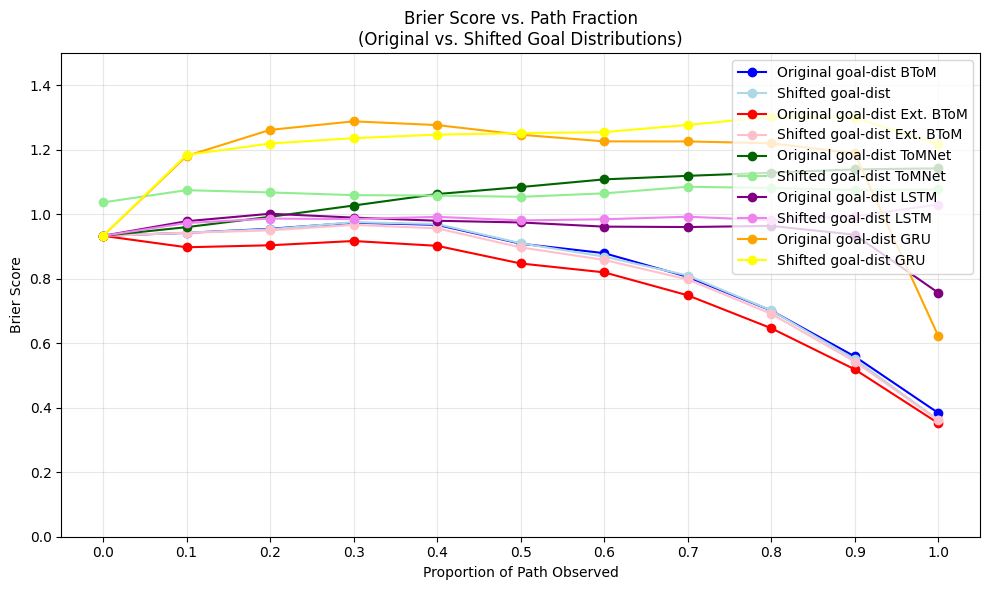

In [173]:
# Fraction grid (must be the same length as the second axis of your arrays)
props = np.linspace(0, 1, btom_arr_orig.shape[1])



plt.figure(figsize=(10,6))

plt.plot(props, btom_mean_orig, '-o', label='Original goal‐dist BToM', color='blue')
plt.plot(props, btom_mean_new, '-o', label='Shifted goal‐dist', color='lightblue')

plt.plot(props, ext_mean_orig, '-o', label='Original goal‐dist Ext. BToM', color='red')
plt.plot(props, ext_mean_new, '-o', label='Shifted goal‐dist Ext. BToM', color='pink')

plt.plot(props, tomnet_mean_orig, '-o', label='Original goal‐dist ToMNet', color='darkgreen')
plt.plot(props, tomnet_mean_new, '-o', label='Shifted goal‐dist ToMNet', color='lightgreen')

plt.plot(props, lstm_mean_orig, '-o', label='Original goal‐dist LSTM', color='purple')
plt.plot(props, lstm_mean_new, '-o', label='Shifted goal‐dist LSTM', color='violet')

plt.plot(props, gru_mean_orig, '-o', label='Original goal‐dist GRU', color='orange')
plt.plot(props, gru_mean_new, '-o', label='Shifted goal‐dist GRU', color='yellow')


plt.xlabel('Proportion of Path Observed')
plt.ylabel('Brier Score')
plt.title('Brier Score vs. Path Fraction\n(Original vs. Shifted Goal Distributions)')
plt.xticks(props)
plt.ylim(0, 1.5)
plt.grid(alpha=0.3)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [198]:
# Convert to arrays
btom_arr_orig = np.array(btom_orig_accuracy)  # shape (N, n_fractions)
btom_arr_new  = np.array(btom_new_accuracy)

ext_arr_orig = np.array(ext_orig_accuracy)  # shape (N, n_fractions)
ext_arr_new  = np.array(ext_new_accuracy)

tomnet_arr_orig = np.array(orig_acc_tomnet)
tomnet_arr_new = np.array(tomnet_new_acc)

lstm_arr_orig = np.array(lstm_orig_accuracy)
lstm_arr_new = np.array(lstm_new_acc)

gru_arr_orig = np.array(gru_orig_accuracy)
gru_arr_new = np.array(gru_new_acc)

btom_mean_orig = btom_arr_orig.mean(axis=0)
btom_mean_new = btom_arr_new.mean(axis=0)

ext_mean_orig = ext_arr_orig.mean(axis=0)
ext_mean_new = ext_arr_new.mean(axis=0)

tomnet_mean_orig = tomnet_arr_orig.mean(axis=0)
tomnet_mean_new = tomnet_arr_new.mean(axis=0)

lstm_mean_orig = lstm_arr_orig.mean(axis=0)
lstm_mean_new = lstm_arr_new.mean(axis=0)

gru_mean_orig = gru_arr_orig.mean(axis=0)
gru_mean_new = gru_arr_new.mean(axis=0)




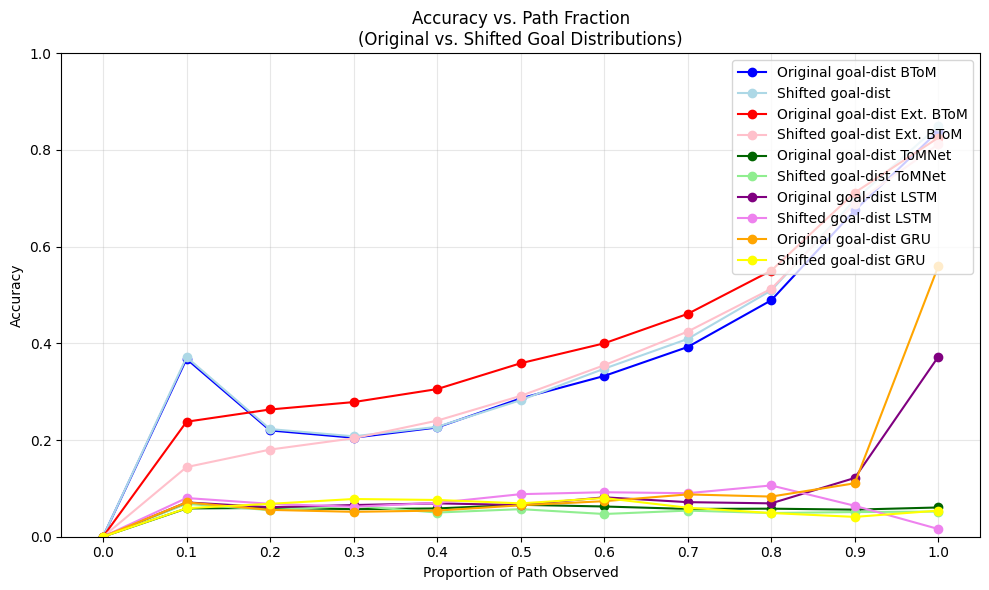

In [176]:
# Fraction grid (must be the same length as the second axis of your arrays)
props = np.linspace(0, 1, btom_arr_orig.shape[1])



plt.figure(figsize=(10,6))

plt.plot(props, btom_mean_orig, '-o', label='Original goal‐dist BToM', color='blue')
plt.plot(props, btom_mean_new, '-o', label='Shifted goal‐dist', color='lightblue')

plt.plot(props, ext_mean_orig, '-o', label='Original goal‐dist Ext. BToM', color='red')
plt.plot(props, ext_mean_new, '-o', label='Shifted goal‐dist Ext. BToM', color='pink')

plt.plot(props, tomnet_mean_orig, '-o', label='Original goal‐dist ToMNet', color='darkgreen')
plt.plot(props, tomnet_mean_new, '-o', label='Shifted goal‐dist ToMNet', color='lightgreen')

plt.plot(props, lstm_mean_orig, '-o', label='Original goal‐dist LSTM', color='purple')
plt.plot(props, lstm_mean_new, '-o', label='Shifted goal‐dist LSTM', color='violet')

plt.plot(props, gru_mean_orig, '-o', label='Original goal‐dist GRU', color='orange')
plt.plot(props, gru_mean_new, '-o', label='Shifted goal‐dist GRU', color='yellow')


plt.xlabel('Proportion of Path Observed')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Path Fraction\n(Original vs. Shifted Goal Distributions)')
plt.xticks(props)
plt.ylim(0, 1)
plt.grid(alpha=0.3)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

wandb

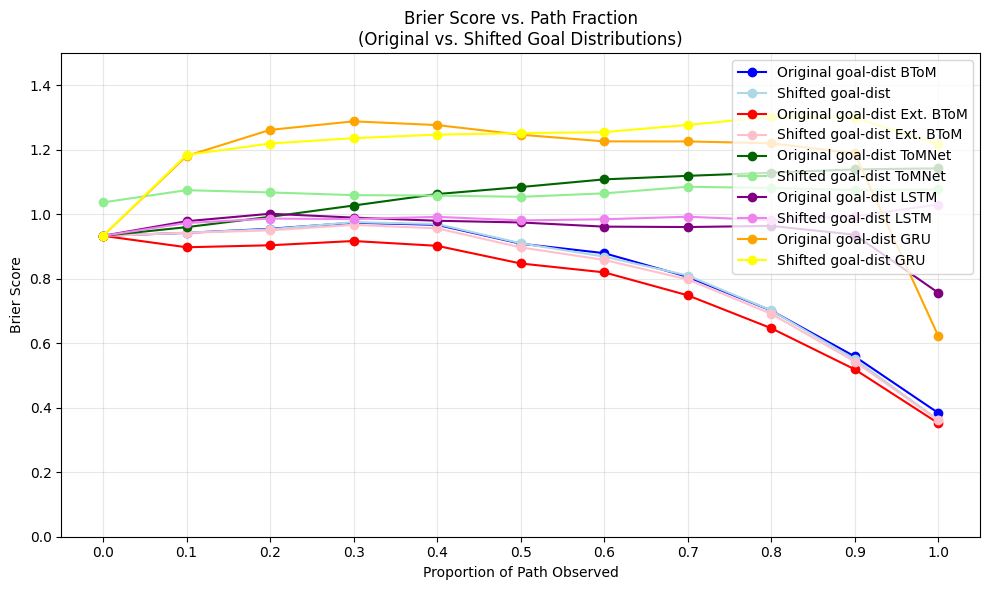

In [197]:
import wandb

# Initialize wandb run (set your project name)
wandb.init(project="baseline_experiment2", name="posteriors_analysis_3 ")

# Fraction grid (must be the same length as the second axis of your arrays)
props = np.linspace(0, 1, btom_arr_orig.shape[1])

# Fraction grid (must be the same length as the second axis of your arrays)
props = np.linspace(0, 1, btom_arr_orig.shape[1])



plt.figure(figsize=(10,6))

plt.plot(props, btom_mean_orig, '-o', label='Original goal‐dist BToM', color='blue')
plt.plot(props, btom_mean_new, '-o', label='Shifted goal‐dist', color='lightblue')

plt.plot(props, ext_mean_orig, '-o', label='Original goal‐dist Ext. BToM', color='red')
plt.plot(props, ext_mean_new, '-o', label='Shifted goal‐dist Ext. BToM', color='pink')

plt.plot(props, tomnet_mean_orig, '-o', label='Original goal‐dist ToMNet', color='darkgreen')
plt.plot(props, tomnet_mean_new, '-o', label='Shifted goal‐dist ToMNet', color='lightgreen')

plt.plot(props, lstm_mean_orig, '-o', label='Original goal‐dist LSTM', color='purple')
plt.plot(props, lstm_mean_new, '-o', label='Shifted goal‐dist LSTM', color='violet')

plt.plot(props, gru_mean_orig, '-o', label='Original goal‐dist GRU', color='orange')
plt.plot(props, gru_mean_new, '-o', label='Shifted goal‐dist GRU', color='yellow')


plt.xlabel('Proportion of Path Observed')
plt.ylabel('Brier Score')
plt.title('Brier Score vs. Path Fraction\n(Original vs. Shifted Goal Distributions)')
plt.xticks(props)
plt.ylim(0, 1.5)
plt.grid(alpha=0.3)
plt.legend(loc='upper right')
plt.tight_layout()
wandb.log({"Brier Score vs Path Fraction": wandb.Image(plt)})
plt.show()


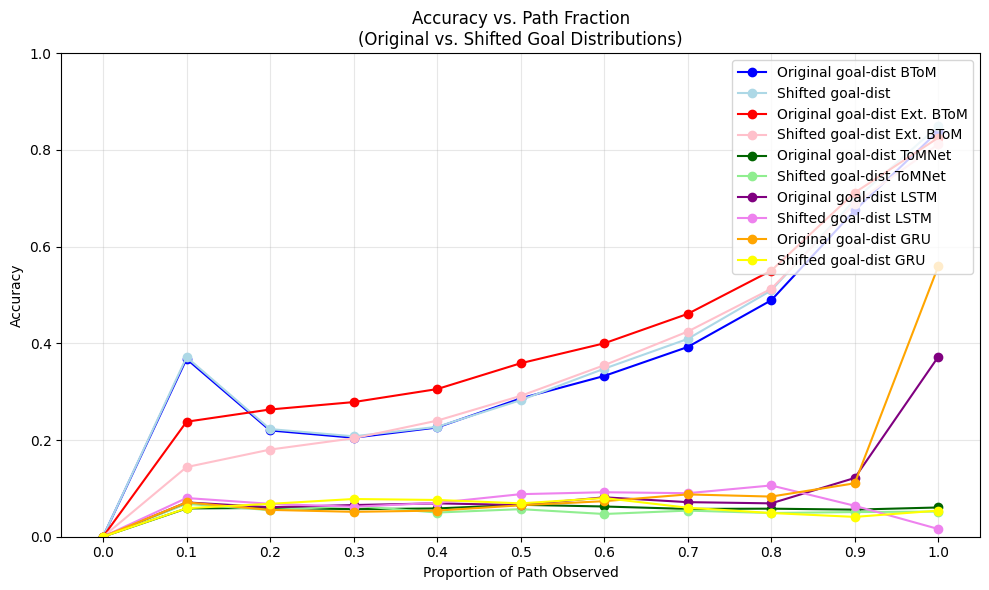

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


In [199]:
plt.figure(figsize=(10,6))

plt.plot(props, btom_mean_orig, '-o', label='Original goal‐dist BToM', color='blue')
plt.plot(props, btom_mean_new, '-o', label='Shifted goal‐dist', color='lightblue')

plt.plot(props, ext_mean_orig, '-o', label='Original goal‐dist Ext. BToM', color='red')
plt.plot(props, ext_mean_new, '-o', label='Shifted goal‐dist Ext. BToM', color='pink')

plt.plot(props, tomnet_mean_orig, '-o', label='Original goal‐dist ToMNet', color='darkgreen')
plt.plot(props, tomnet_mean_new, '-o', label='Shifted goal‐dist ToMNet', color='lightgreen')

plt.plot(props, lstm_mean_orig, '-o', label='Original goal‐dist LSTM', color='purple')
plt.plot(props, lstm_mean_new, '-o', label='Shifted goal‐dist LSTM', color='violet')

plt.plot(props, gru_mean_orig, '-o', label='Original goal‐dist GRU', color='orange')
plt.plot(props, gru_mean_new, '-o', label='Shifted goal‐dist GRU', color='yellow')


plt.xlabel('Proportion of Path Observed')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Path Fraction\n(Original vs. Shifted Goal Distributions)')
plt.xticks(props)
plt.ylim(0, 1)
plt.grid(alpha=0.3)
plt.legend(loc='upper right')
plt.tight_layout()
wandb.log({"Accuracy vs Path Fraction": wandb.Image(plt)})
plt.show()

wandb.finish()

# Brier Scores and Accuracy for the Original Data

In [139]:
# Robustly compute scores for all models, handling int/str keys for LSTM/GRU posteriors
orig_scores_btom = []
orig_scores_ext = []
orig_scores_lstm = []
orig_scores_gru = []

for episode in range(len(goal_data)):
    for i, agent in enumerate(agents):
        # BToM
        path = path_data[episode][agent.id]
        posteriors = posteriors_data[episode][agent.id]
        min_len = min(len(path), len(posteriors))
        orig_scores_btom.append(brier_along_path(
            path[:min_len],
            goal_data[episode][agent.id],
            posteriors[:min_len],
            goals
        ))
        # Extended BToM
        ext_post = ext_posteriors_data[episode][agent.id]
        min_len_ext = min(len(path), len(ext_post))
        orig_scores_ext.append(brier_along_path(
            path[:min_len_ext],
            goal_data[episode][agent.id],
            ext_post[:min_len_ext],
            goals
        ))
        # LSTM
        lstm_ep = lstm_posteriors[episode]
        if isinstance(lstm_ep, dict):
            try:
                lstm_post = lstm_ep[agent.id]
            except KeyError:
                try:
                    lstm_post = lstm_ep[str(agent.id)]
                except KeyError:
                    continue
        elif isinstance(lstm_ep, list):
            lstm_post = lstm_ep[i]
        else:
            continue
        min_len_lstm = min(len(path), len(lstm_post))
        orig_scores_lstm.append(brier_along_path(
            path[:min_len_lstm],
            goal_data[episode][agent.id],
            lstm_post[:min_len_lstm],
            goals
        ))
        # GRU
        gru_ep = gru_posteriors[episode]
        if isinstance(gru_ep, dict):
            try:
                gru_post = gru_ep[agent.id]
            except KeyError:
                try:
                    gru_post = gru_ep[str(agent.id)]
                except KeyError:
                    continue
        elif isinstance(gru_ep, list):
            gru_post = gru_ep[i]
        else:
            continue
        min_len_gru = min(len(path), len(gru_post))
        orig_scores_gru.append(brier_along_path(
            path[:min_len_gru],
            goal_data[episode][agent.id],
            gru_post[:min_len_gru],
            goals
        ))

In [145]:
len(orig_scores_btom), len(orig_scores_ext), len(orig_scores_lstm), len(orig_scores_gru), len(orig_scores_tomnet)

(10000, 10000, 2000, 2000, 2000)

In [140]:
# Robustly compute accuracy for all models, handling int/str keys for LSTM/GRU posteriors
btom_orig_accuracy = []
ext_orig_accuracy = []
lstm_orig_accuracy = []
gru_orig_accuracy = []

for episode in range(len(goal_data)):
    for i, agent in enumerate(agents):
        # BToM
        path = path_data[episode][agent.id]
        posteriors = posteriors_data[episode][agent.id]
        min_len = min(len(path), len(posteriors))
        btom_orig_accuracy.append(accuracy_along_path(
            path[:min_len],
            goal_data[episode][agent.id],
            posteriors[:min_len],
            goals
        ))
        # Extended BToM
        ext_post = ext_posteriors_data[episode][agent.id]
        min_len_ext = min(len(path), len(ext_post))
        ext_orig_accuracy.append(accuracy_along_path(
            path[:min_len_ext],
            goal_data[episode][agent.id],
            ext_post[:min_len_ext],
            goals
        ))
        # LSTM
        lstm_ep = lstm_posteriors[episode]
        if isinstance(lstm_ep, dict):
            try:
                lstm_post = lstm_ep[agent.id]
            except KeyError:
                try:
                    lstm_post = lstm_ep[str(agent.id)]
                except KeyError:
                    continue
        elif isinstance(lstm_ep, list):
            lstm_post = lstm_ep[i]
        else:
            continue
        min_len_lstm = min(len(path), len(lstm_post))
        lstm_orig_accuracy.append(accuracy_along_path(
            path[:min_len_lstm],
            goal_data[episode][agent.id],
            lstm_post[:min_len_lstm],
            goals
        ))
        # GRU
        gru_ep = gru_posteriors[episode]
        if isinstance(gru_ep, dict):
            try:
                gru_post = gru_ep[agent.id]
            except KeyError:
                try:
                    gru_post = gru_ep[str(agent.id)]
                except KeyError:
                    continue
        elif isinstance(gru_ep, list):
            gru_post = gru_ep[i]
        else:
            continue
        min_len_gru = min(len(path), len(gru_post))
        gru_orig_accuracy.append(accuracy_along_path(
            path[:min_len_gru],
            goal_data[episode][agent.id],
            gru_post[:min_len_gru],
            goals
        ))

Reference only

In [ ]:
"""
# --- LSTM Implementation (Old Data) ---
from real_world_src.models.lstm import (
    SimpleLSTM, LSTMDataset, lstm_collate_fn,
    train_lstm_model, evaluate_lstm_model, predict_goal_posterior
)
from torch.utils.data import DataLoader

# Build node2idx and goal2idx
all_nodes = list(campus.G_undirected.nodes())
node2idx  = {n:i for i,n in enumerate(all_nodes)}
goal2idx = {g:i for i,g in enumerate(goals)}

# Prepare dataset and dataloader
lstm_dataset = LSTMDataset(path_data, goal_data, node2idx, goal2idx)
lstm_loader = DataLoader(lstm_dataset, batch_size=32, shuffle=True, collate_fn=lstm_collate_fn)

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Instantiate and train the model
lstm_model = SimpleLSTM(num_nodes=len(node2idx), num_goals=len(goal2idx)).to(device)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)
train_lstm_model(lstm_model, lstm_loader, optimizer, device, num_epochs=10)

def get_lstm_posteriors(path_data, goal_data, agents, test_agent_ids, lstm_model, node2idx, goal2idx, device):
    lstm_posteriors = {}
    for episode in range(len(goal_data)):
        lstm_posteriors[episode] = {}
        for agent in agents:
            if agent.id not in test_agent_ids:
                continue
            path = path_data[episode][agent.id]
            posteriors_along_path = []
            for t in range(1, len(path)+1):
                subpath = path[:t]
                posterior = predict_goal_posterior(lstm_model, subpath, node2idx, goal2idx, device)
                posteriors_along_path.append(posterior)
            lstm_posteriors[episode][agent.id] = posteriors_along_path
    return lstm_posteriors

lstm_posteriors = get_lstm_posteriors(path_data, goal_data, agents, test_agent_ids, lstm_model, node2idx, goal2idx, device)

# LSTM Scores (old data)
lstm_scores = []
for episode in range(len(goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        lstm_scores.append(brier_along_path(
            path_data[episode][agent.id],
            goal_data[episode][agent.id],
            lstm_posteriors[episode][agent.id],
            goals
        ))
lstm_acc = []
for episode in range(len(goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        lstm_acc.append(accuracy_along_path(
            path_data[episode][agent.id],
            goal_data[episode][agent.id],
            lstm_posteriors[episode][agent.id],
            goals
        ))

# --- LSTM Implementation (New Data) ---
# Prepare dataset and dataloader for new data
lstm_new_dataset = LSTMDataset(new_path_data, new_goal_data, node2idx, goal2idx)
lstm_new_loader = DataLoader(lstm_new_dataset, batch_size=32, shuffle=True, collate_fn=lstm_collate_fn)

# Retrain or reuse model as needed (here, reuse for robustness test)
lstm_new_posteriors = get_lstm_posteriors(new_path_data, new_goal_data, agents, test_agent_ids, lstm_model, node2idx, goal2idx, device)

# LSTM Scores (new data)
lstm_new_scores = []
for episode in range(len(new_goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        lstm_new_scores.append(brier_along_path(
            new_path_data[episode][agent.id],
            new_goal_data[episode][agent.id],
            lstm_new_posteriors[episode][agent.id],
            goals
        ))
lstm_new_acc = []
for episode in range(len(new_goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        lstm_new_acc.append(accuracy_along_path(
            new_path_data[episode][agent.id],
            new_goal_data[episode][agent.id],
            lstm_new_posteriors[episode][agent.id],
            goals
        ))

# --- GRU Implementation (Old Data) ---
from real_world_src.models.gru import (
    SimpleGRU, GRUDataset, gru_collate_fn,
    train_gru_model, evaluate_gru_model, predict_goal_posterior_gru
)
from torch.utils.data import DataLoader

gru_dataset = GRUDataset(path_data, goal_data, node2idx, goal2idx)
gru_loader = DataLoader(gru_dataset, batch_size=32, shuffle=True, collate_fn=gru_collate_fn)

gru_model = SimpleGRU(num_nodes=len(node2idx), num_goals=len(goal2idx)).to(device)
gru_optimizer = torch.optim.Adam(gru_model.parameters(), lr=1e-3)
train_gru_model(gru_model, gru_loader, gru_optimizer, device, num_epochs=10)

def get_gru_posteriors(path_data, goal_data, agents, test_agent_ids, gru_model, node2idx, goal2idx, device):
    gru_posteriors = {}
    for episode in range(len(goal_data)):
        gru_posteriors[episode] = {}
        for agent in agents:
            if agent.id not in test_agent_ids:
                continue
            path = path_data[episode][agent.id]
            posteriors_along_path = []
            for t in range(1, len(path)+1):
                subpath = path[:t]
                posterior = predict_goal_posterior_gru(gru_model, subpath, node2idx, goal2idx, device)
                posteriors_along_path.append(posterior)
            gru_posteriors[episode][agent.id] = posteriors_along_path
    return gru_posteriors

gru_posteriors = get_gru_posteriors(path_data, goal_data, agents, test_agent_ids, gru_model, node2idx, goal2idx, device)

gru_scores = []
for episode in range(len(goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        gru_scores.append(brier_along_path(
            path_data[episode][agent.id],
            goal_data[episode][agent.id],
            gru_posteriors[episode][agent.id],
            goals
        ))
gru_acc = []
for episode in range(len(goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        gru_acc.append(accuracy_along_path(
            path_data[episode][agent.id],
            goal_data[episode][agent.id],
            gru_posteriors[episode][agent.id],
            goals
        ))

# --- GRU Implementation (New Data) ---
gru_new_dataset = GRUDataset(new_path_data, new_goal_data, node2idx, goal2idx)
gru_new_loader = DataLoader(gru_new_dataset, batch_size=32, shuffle=True, collate_fn=gru_collate_fn)

gru_new_posteriors = get_gru_posteriors(new_path_data, new_goal_data, agents, test_agent_ids, gru_model, node2idx, goal2idx, device)

gru_new_scores = []
for episode in range(len(new_goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        gru_new_scores.append(brier_along_path(
            new_path_data[episode][agent.id],
            new_goal_data[episode][agent.id],
            gru_new_posteriors[episode][agent.id],
            goals
        ))
gru_new_acc = []
for episode in range(len(new_goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        gru_new_acc.append(accuracy_along_path(
            new_path_data[episode][agent.id],
            new_goal_data[episode][agent.id],
            gru_new_posteriors[episode][agent.id],
            goals
        ))
        """